(content:references:eclipse_part2)=
# Eclipse Morphology Part 2: *Low-Dimensional Representations*

***Author: Marc Hon***

We will continue from the previous chapter, in which we examined the diversity of binary light curve morphology and discussed approaches on formatting the data.

In [1]:
import os
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib, warnings
from astropy.timeseries import TimeSeries
from pathlib import Path

warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'
plt.style.use('science')
fs = 18

We will utilize a dataset containing formatted phase-folded light curves. These have been median-binned into a fixed size of 250 phase bins from within the range $[-0.5, 0.5]$.

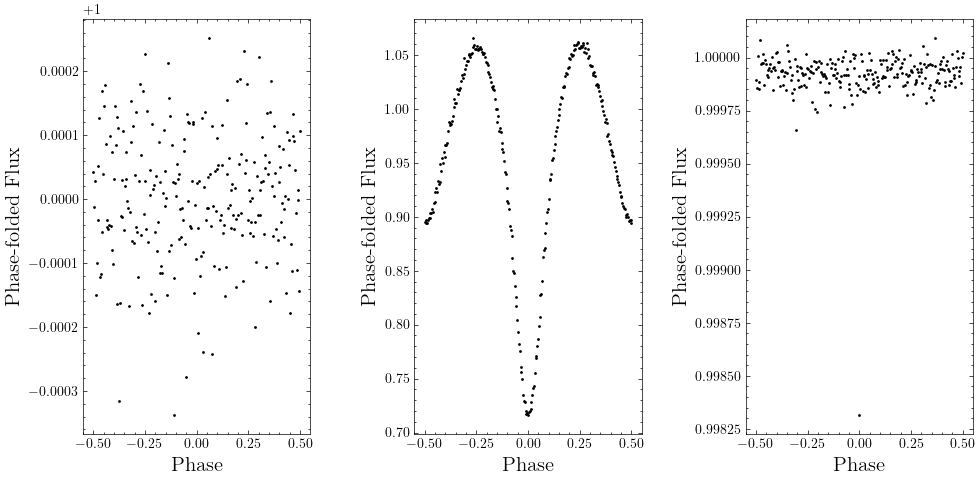

In [2]:
dataset = np.load(os.path.join(data_folder_path, 'KeplerEB_Filtered.npz'))

## Display three random light curves from the dataset

randint = np.random.randint(0, len(dataset['flux']), 3)

fig = plt.figure(figsize=(10, 5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)

for idx, ax in zip(randint,[ax1,ax2,ax3]):
    ax.scatter(dataset['flux'][idx][0], dataset['flux'][idx][1], s=1, c='k')
    ax.set_xlabel('Phase', fontsize=fs-3)
    ax.set_ylabel('Phase-folded Flux', fontsize=fs-3)    

plt.tight_layout(w_pad=2)
plt.show()

## Exploring the dataset using Principal Components Analysis (PCA).

PCA is a linear approach to dimensionality reduction that projects data along the 
the directions of maximum variance (i.e., the **principal components**) within a dataset. These principal components are identified as the eigenvectors of the dataset's covariance matrix that have the largest eigenvalues. In other words, each principal component is a weighted combination of the dimensions of the original data, with the weights  calculated through the data's covariance matrix.

In practice, PCA can be cheap and effecient approach for identifying global patterns and trends within a dataset.


In [3]:
from sklearn.decomposition import PCA
from tslearn.preprocessing import TimeSeriesScalerMinMax

pca_ = PCA(n_components=2)
flux_pca = pca_.fit_transform(dataset['flux'][:, 1, :])

print(f'Variance Explained by PCA First Dimension: {np.round(pca_.explained_variance_ratio_[0]*100.)}%')
print(f'Variance Explained by PCA Second Dimension: {np.round(pca_.explained_variance_ratio_[1]*100.)}%')

Variance Explained by PCA First Dimension: 79.0%
Variance Explained by PCA Second Dimension: 10.0%


The phase-folded light curves are projected into two dimensions along their principal components. The explained variance ratio suggests that most of the variation in light curve morphology would be presented along the x-axis. However, a visual inspection of the projection shown below indicates that this isn't quite the case!
```{note}
Hover over each point to visualize the light curve.
```

In [4]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import linear_cmap
from bokeh.models import ColumnDataSource, HoverTool,LinearColorMapper, ColorBar, FixedTicker, BasicTicker, PrintfTickFormatter
output_notebook()

kics = dataset['kic']
def bokeh_projection_pca(projection, xlabel, ylabel, title):

    pca_df = pd.DataFrame({'pca_1': projection[:,0],
                          'pca_2': projection[:,1],
                            'kic': kics,
                          'image_url': [f'https://raw.githubusercontent.com/mtyhon/image_data/refs/heads/master/kepler_eb/{str(idx).zfill(8)}.png' for idx in kics]})

    p = figure(width=700, height=600, title=title)

    p.circle('pca_1', 'pca_2', size=5.5, source=ColumnDataSource(pca_df), line_color='black', line_width=0.2,)
    hover = HoverTool(tooltips = f"""
        <div>
            <div style="font-size: {fs}px;"><strong>KIC @kic </strong></div>
            <div><img src="@image_url" alt="" width="400" /></div>
        </div>
    """)
    p.add_tools(hover)
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    p.xaxis.axis_label_text_font_size = f'{fs}pt' 
    p.yaxis.axis_label_text_font_size = f'{fs}pt' 
    p.xaxis.major_label_text_font_size = f'{fs-2}pt' 
    p.yaxis.major_label_text_font_size = f'{fs-2}pt' 
    p.title.text_font_size = f'{fs-3}pt' 
    p.title.text_color = 'black'  
    p.title.text_font_style = 'bold' 
    show(p)

bokeh_projection_pca(flux_pca, 
                xlabel = f"PCA Dimension 1, Explained Ratio: {np.round(pca_.explained_variance_ratio_[0]*100.)}%",
                ylabel = f"PCA Dimension 2,  Explained Ratio: {np.round(pca_.explained_variance_ratio_[1]*100.)}%",
                title = "Phase-Folded Light Curve PCA")


Loading BokehJS ...

A caveat with using PCA is that the method is highly sensitive to the scale of the data. Because PCA analyzes the covariance within the dataset, having numerical features that are strongly dissimilar in range can accentuate the wrong aspects in the dataset. 

In our dataset, the minimum and maximum flux values can change significantly across stars due to a difference in eclipse depths or the underlying stellar variability. Because the goal is to focus specifically on the morphology, rather than the depth of the eclipses, the range of flux values should be normalized. As opposed to typical datasets, we __do not normalize along phase bins__ across the whole dataset, but we normalize across __flux values for each instance (light curve)__. We use the handy library [`tslearn`](https://tslearn.readthedocs.io) to accomplish this.

```{important}
Normalizing across the whole dataset will distort the shape of each light curve based on the overall statistics of the dataset. Consequently, applying this projection to new data will be dependent on the statistics of the original dataset. Per-sample normalization is more agnostic to the dataset's statistics and is often more desirable.
```

In [5]:
from tslearn.preprocessing import TimeSeriesScalerMinMax

scaler = TimeSeriesScalerMinMax(value_range=(0, 1))
scaled_ts = scaler.fit_transform(dataset['flux'][:, 1, :])

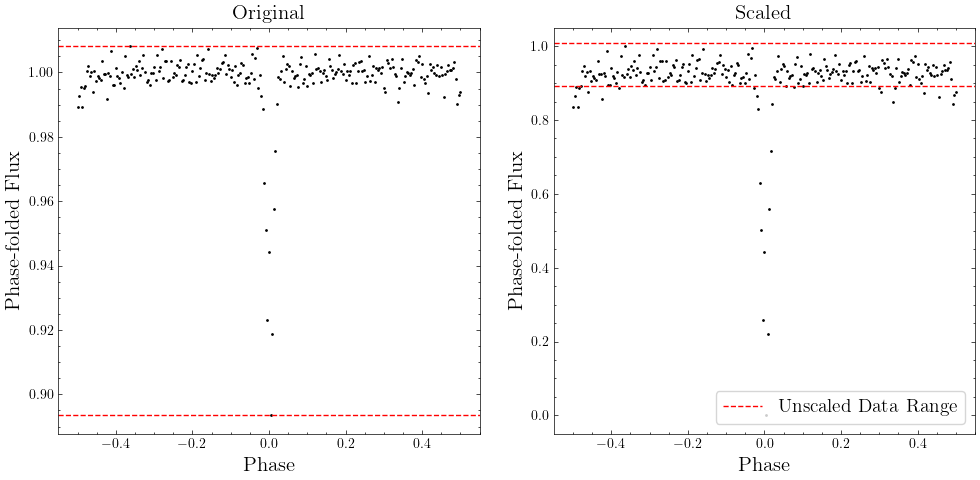

In [6]:
idx = 133

fig = plt.figure(figsize=(10, 5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
ax1.scatter(dataset['flux'][idx][0], dataset['flux'][idx][1], s=1, c='k')
ax2.scatter(dataset['flux'][idx][0], scaled_ts[idx], s=1, c='k')
[ax.set_xlabel('Phase', fontsize=fs-3) for ax in [ax1,ax2]]
[ax.set_ylabel('Phase-folded Flux', fontsize=fs-3) for ax in [ax1,ax2]]
ax1.set_title('Original', fontsize=fs-3); ax2.set_title('Scaled', fontsize=fs-3)
ax1.axhline(y=max(dataset['flux'][idx][1]), ls='--', c='r'); ax1.axhline(y=min(dataset['flux'][idx][1]), ls='--', c='r')
ax2.axhline(y=max(dataset['flux'][idx][1]), ls='--', c='r', label='Unscaled Data Range'); ax2.axhline(y=min(dataset['flux'][idx][1]), ls='--', c='r')
ax2.legend(loc='lower right', prop={'size': fs-4}, frameon=True)

plt.tight_layout(w_pad=2)
plt.show()

Let's observe the projection now with scaled data.

In [7]:
pca_scaled = PCA(n_components=2)
scaled_flux_pca = pca_scaled.fit_transform(scaled_ts[:, :].squeeze())

In [8]:
bokeh_projection_pca(scaled_flux_pca, 
                xlabel = f"PCA Dimension 1, Explained Ratio: {np.round(pca_scaled.explained_variance_ratio_[0]*100.)}%",
                ylabel = f"PCA Dimension 2,  Explained Ratio: {np.round(pca_scaled.explained_variance_ratio_[1]*100.)}%",
                title = "Phase-Folded Light Curve PCA (Scaled)")

The improvements to the projection are evident:
- Smooth and distinct light curve variations along the x-axis, which contains most of the explained ratio.  
- Clusters form in the lower-dimensional space that are clearly interpretable between ellipsoidal/detached binary shapes.
- Projection outliers corresponding to targets of astrophysical interest.

(content:references:eclipse_lle)=
## Exploring the dataset using Locally Linear Embedding (LLE).

Local Linear Embedding (LLE) is a **non-linear** dimensionality reduction technique, where each data point is reconstructed as a weighted sum of its (user-defined) $K$ nearest neighbors using weights that minimize its reconstruction error in the projected space. These weights are kept fixed when projecting the data into a lower-dimensional space, which is done by solving an eigenvalue problem.

```{figure} images/lle.jpeg
---
height: 450px
height: 450px
name: lle
---
Schematic of the Locally Linear Embedding method. In (1), neighbours are assigned to each data point. In (2) , weights that reconstruct each data point the best from its neighbors are computed by solving a constrained least-squares problem. Each data point is embedded in a low-dimensional embedding in (3), with the constraint that points are only reconstructed from neighbors. Image from {cite}`Roweis_2000`.
```
We can apply the algorithm using `scikit-learn`'s implementation:

In [9]:
from sklearn.manifold import LocallyLinearEmbedding

seed = 1307; reg = 1e-2
lle_embedding = LocallyLinearEmbedding(n_neighbors = 15, reg = reg,
                                       n_components=3, random_state = seed).fit_transform(scaled_ts[:, :].squeeze())
lle_embedding = LocallyLinearEmbedding(n_neighbors = 15, reg = reg,
                                       n_components=2, random_state = seed).fit_transform(lle_embedding)

In [10]:
def bokeh_projection_lle(projection, xlabel, ylabel, title, color=None):
        
    pca_df = pd.DataFrame({'pca_1': projection[:,0],
                          'pca_2': projection[:,1],
                            'kic': kics,
                           'color': color,
                          'image_url': [f'https://raw.githubusercontent.com/mtyhon/image_data/refs/heads/master/kepler_eb/{str(idx).zfill(8)}.png' for idx in kics]})

    p = figure(width=700, height=600, title=title)
    
    if color is not None:
        color_mapper = LinearColorMapper(palette="Viridis256", low=min(pca_df.color), high=max(pca_df.color))
        p.circle('pca_1', 'pca_2', size=5.5, source=ColumnDataSource(pca_df), 
                 color=linear_cmap('color', 'Viridis256', 
                                   min(pca_df.color), max(pca_df.color)),line_color='black',
                 line_width=0.2,)
        color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), 
                             label_standoff=12, location=(0,0),
                             title='Literature Morphological Parameter (c)',
                     major_label_text_font_size=f"{fs-3}pt")
        p.add_layout(color_bar, 'right')
    else:
        p.circle('pca_1', 'pca_2', size=5.5, source=ColumnDataSource(pca_df), color='royalblue',line_color='black', line_width=0.2,)
    
    hover = HoverTool(tooltips = f"""
        <div>
            <div style="font-size: {fs}px;"><strong>KIC @kic </strong></div>
            <div><img src="@image_url" alt="" width="400" /></div>
        </div>
    """)
    p.add_tools(hover)
    p.xaxis.axis_label = xlabel; p.yaxis.axis_label = ylabel
    p.xaxis.axis_label_text_font_size = f'{fs}pt' ;p.yaxis.axis_label_text_font_size = f'{fs}pt' 
    p.xaxis.major_label_text_font_size = f'{fs-2}pt' ;p.yaxis.major_label_text_font_size = f'{fs-2}pt' 
    p.title.text_font_size = f'{fs-3}pt' ;p.title.text_color = 'black'  ; p.title.text_font_style = 'bold' 
    show(p)

bokeh_projection_lle(lle_embedding, 
                xlabel = "LLE Embedding Dimension 1",
                ylabel = "LLE Embedding Dimension 2",
                title = "Phase-Folded Light Curve LLE (Scaled)")

Notice something interesting being performed in the above dimensionality reduction -- a twofold application of LLE! LLE is first applied to map the light curves down into three dimensions, and another LLE mapping is then applied to reduce the dimensionality to two. This was the approach performed by {cite}`Matijevic_2012`, with the goal of defining a numerical parameter `morph` describing the morphology of the light curve:

```{figure} images/eb_morph.jpg
---
height: 550px
name: eb-morph
---
Plot corresponding to Figure 3 from {cite}`Matijevic_2012`. A morphological parameter `c` here quantifies the overall shape of the phase-folded light curves; a value of 0 indicates a detached system, whereas a value of 1 indicates strong ellipsoidal variations. 
```
Let us supplement our LLE projection with the value of `c` reported in the _Kepler_ Eclipsing Binary Catalog.

In [11]:
ebcat = pd.read_csv(os.path.join(data_folder_path, 'eb_morph.dat')).drop_duplicates(subset='kic')

bokeh_projection_lle(lle_embedding, 
                xlabel = "LLE Embedding Dimension 1",
                ylabel = "LLE Embedding Dimension 2",
                title = "Phase-Folded Light Curve LLE (Scaled)",
                 color = [ebcat.morph.values[np.where(ebcat.kic.values == k)[0][0]] for k in kics])

```{note}
What does `c=-1` correspond to?
```

### Defining a Morphological Parameter

It is convenient to describe the shape of the eclipsing binary through a single number. Given the elongated LLE projection, {cite}`Matijevic_2012` fit a spline through the projection and scale the spline to a range of 0 and 1. 

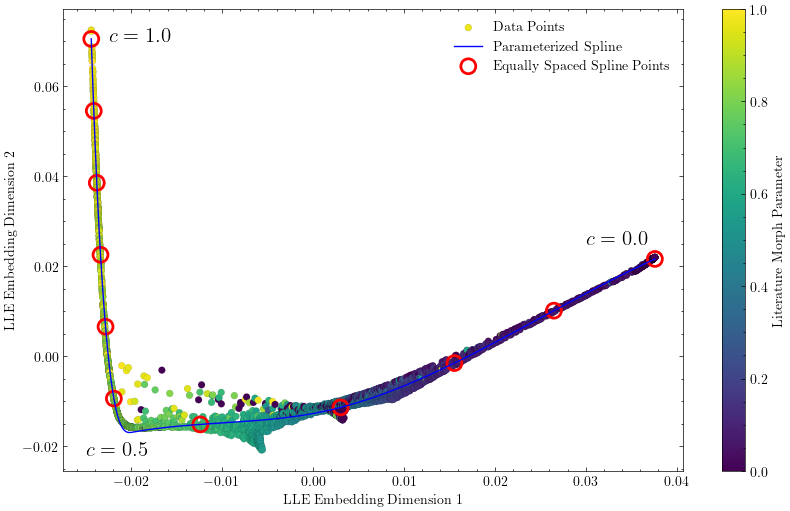

In [25]:
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad

x, y = np.sort(lle_embedding[:,0]), lle_embedding[np.argsort(lle_embedding[:,0]), 1]
spline = UnivariateSpline(x, y, s=0.0075, k=3)

# Define the function to compute the arc length integrand: sqrt((dx/dxi)^2 + (dy/dxi)^2)
def arc_length_integrand(xi):
    dx = spline.derivative(n=1)(xi)  # derivative of spline
    return np.sqrt(1 + dx**2)

# Compute the cumulative arc length by integrating the differential arc length
arc_lengths = [0]  # Start with zero arc length at the first point
for i in range(1, len(x)):
    arc_length_segment, _ = quad(arc_length_integrand, x[i-1], x[i])
    arc_lengths.append(arc_lengths[-1] + arc_length_segment)

arc_lengths = np.array(arc_lengths)

# Define the number of equally spaced points along the arc length
num_points = 11
target_arc_lengths = np.linspace(0, arc_lengths[-1], num_points)

# Interpolate to find x-coordinates for equally spaced arc lengths
x_smooth = np.interp(target_arc_lengths, arc_lengths, x)
y_smooth = spline(x_smooth)

fig = plt.figure(figsize=(10, 6))
im = plt.scatter(x, y, label='Data Points', 
            c=np.array([ebcat.morph.values[np.where(ebcat.kic.values == k)[0][0]] for k in kics])[np.argsort(lle_embedding[:,0])],
            s=25, vmin=0, edgecolor='k', lw=0.05)
plt.plot(x, spline(x), label='Parameterized Spline', color='blue')
plt.scatter(x_smooth[:], y_smooth[:], color='none', edgecolor='red', s=115, lw=2,
            label='Equally Spaced Spline Points')

plt.xlabel('LLE Embedding Dimension 1')
plt.ylabel('LLE Embedding Dimension 2')
plt.colorbar(im, label='Literature Morph Parameter')
plt.text(x=-0.0225, y=0.07, s='$c=1.0$', fontsize=fs-3)
plt.text(x=0.03, y=0.025, s='$c=0.0$', fontsize=fs-3)
plt.text(x=-0.025, y=-0.022, s='$c=0.5$', fontsize=fs-3)

plt.legend(); plt.show()

In literature, values of $c < 0.5$ indicate a detached binary, but this isn't quite so in the above projection. This is certainly due to the difference in dataset, implementation, and random seeding. In practice, morphological parameters can be assigned to new data by the following:

- Pre-processing the newly observed binary's phase-folded light curve
- Mapping the light curve into 2D using the existing transformation
- Finding the nearest point on the spline to the new data's projection, which can be done using K-Nearest Neighbours

## Projections by Clustering


With a fixed-length time series dataset, it is possible to perform clustering to find highly representative shapes based on a particular distance metric. The resulting dimensions onto which data will be projected will be the distances or similarities of each data point to the cluster.

As an example, we examine clustering using Euclidean distances with `tslearn`'s `TimeSeriesKMeans`.

In [12]:
from tslearn.clustering import TimeSeriesKMeans

km = TimeSeriesKMeans(n_clusters=2, metric="euclidean", max_iter=5,
                      random_state=1337).fit(scaled_ts)
cluster_labels = km.predict(scaled_ts)
distance_to_clusters = km.transform(scaled_ts)

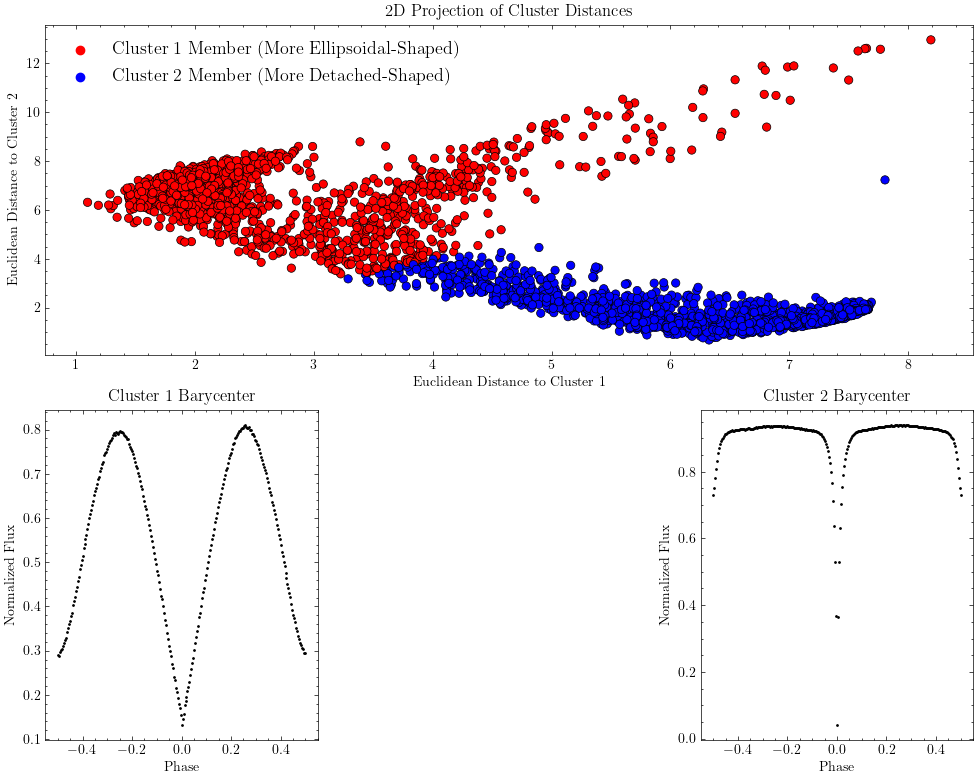

In [13]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 3); ax1, ax2, ax3 = fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 2])
ax1.scatter(distance_to_clusters[:,0], distance_to_clusters[:,1], c=cluster_labels, cmap='bwr_r', edgecolor='k', lw=0.5)
ax1.set_title('2D Projection of Cluster Distances'); ax1.set_xlabel('Euclidean Distance to Cluster 1'); ax1.set_ylabel('Euclidean Distance to Cluster 2')
ax1.scatter([],[], c='r', label='Cluster 1 Member (More Ellipsoidal-Shaped)'); ax1.scatter([],[], c='blue', label='Cluster 2 Member (More Detached-Shaped)')
ax1.legend(prop={'size': fs-5}, loc='upper left')

[ax.scatter(np.linspace(-.5, .5, 251), km.cluster_centers_[i], s=1, c='k') for i, ax in enumerate([ax2,ax3])]
[ax.set_xlabel('Phase') for ax in [ax2,ax3]]; [ax.set_ylabel('Normalized Flux') for ax in [ax2,ax3]]; [ax.set_title(f'Cluster {i+1} Barycenter') for i, ax in enumerate([ax2, ax3])]

plt.tight_layout(h_pad=0)
plt.show()

The KMeans approach identifies the $k$ most representative light curves (**barycenters**) to form cluster centroids. These barycenters can be thought of as the mean or center of mass of the cluster, acting as the point that minimizes the distance to all other members of the assigned cluster.

Unsurprisingly, eclipse shapes corresponding to ellipsoidal variations (**cluster 1**) and detached binaries (**cluster 2**) are the most representative shapes across the dataset. The projection therefore has a natural interpretation: how similar are the distances between light curves to the ellipsoidal case (x-axis) and the detached case (y-axis)?

In [14]:
from matplotlib import cm

def convert_color(rgba_color, array=False):
    """Convert an RGBA color from 0-1 range to a hexadecimal string or an array of colors."""  
    def rgba_to_hex(rgba):
        """Helper function to convert a single RGBA color to hex."""
        return '#%02x%02x%02x' % (int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255))
    if not array:
        return rgba_to_hex(rgba_color)
    else:
        return np.apply_along_axis(lambda rgba: rgba_to_hex(rgba), 1, rgba_color)

    
def bokeh_projection_clust(projection, cluster_labels, xlabel, ylabel, title):
   
    category_map = {f'Cluster {i+1}': cat for i, cat in enumerate(np.unique(cluster_labels))}
    colormap = cm.get_cmap('Set2', len(category_map)) 
    
    pca_df = pd.DataFrame({'proj_1': projection[:,0],
                          'proj_2': projection[:,1],
                            'kic': kics,
                           'cluster_labels': [f'Cluster {idx + 1}' for idx in cluster_labels],
                           'cluster_color': convert_color(colormap(cluster_labels), True), 
                          'image_url': [f'https://raw.githubusercontent.com/mtyhon/image_data/refs/heads/master/kepler_eb/{str(idx).zfill(8)}.png' for idx in kics]})

    p = figure(width=750, height=800, title=title)

    low = min(cluster_labels); high = max(cluster_labels)
    
    ticks = np.linspace(low+0.5/len(category_map), high-0.5/len(category_map), len(category_map)) if len(category_map) == 2 else  np.linspace(low + 0.125 * (high - low), high - 0.125 * (high - low), len(category_map))
    
    labels = {tick: name for tick, name in zip(ticks, category_map.keys())}

    color_mapper = LinearColorMapper(palette=[convert_color(colormap(i)) for i in range(colormap.N)], low=low, high=high)
    p.circle('proj_1', 'proj_2', size=10.5, source=ColumnDataSource(pca_df), color='cluster_color',
            line_color='black', line_width=0.2, )
    
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0),
                     ticker=FixedTicker(ticks=ticks),
                     major_label_overrides=labels,
                     major_label_text_font_size="25pt", orientation='horizontal')
    
    hover = HoverTool(tooltips = f"""
        <div>
            <div style="font-size: {fs}px;"><strong>KIC @kic </strong></div>
            <div><img src="@image_url" alt="" width="400" /></div>
        </div>
    """)
    
    p.add_layout(color_bar, 'above'); p.add_tools(hover)
    p.xaxis.axis_label = xlabel; p.yaxis.axis_label = ylabel
    p.xaxis.axis_label_text_font_size = f'{fs}pt' ;p.yaxis.axis_label_text_font_size = f'{fs}pt' 
    p.xaxis.major_label_text_font_size = f'{fs-2}pt' ;p.yaxis.major_label_text_font_size = f'{fs-2}pt' 
    p.title.text_font_size = f'{fs-3}pt' ;p.title.text_color = 'black'  ;p.title.text_font_style = 'bold' 
    show(p)
    
bokeh_projection_clust(distance_to_clusters, cluster_labels, xlabel='Euclidean Distance to Cluster 1',
                      ylabel='Euclidean Distance to Cluster 2', title='Euclidean Clustering Projection')

```{admonition} Qualitative vs. quantitative
:class: seealso
From the above example, do you agree that all cluster 1 (2) members are more ellipsoidal-(detached-)shaped? Can you find counterexamples and describe why they have been labelled as such?
```
### More representative projections

We certainly do not expect the entire eclipsing binary dataset to be adequately represented by only two types of eclipse shapes! By increasing the number of clusters used in KMeans, the number of templates to which distances/similarities are calculated are increased accordingly. This increases the representation flexibility of the projection at the cost of increasing the number of resulting dimensions.

Let's double the number of clusters from $k=2$ to $k=4$:

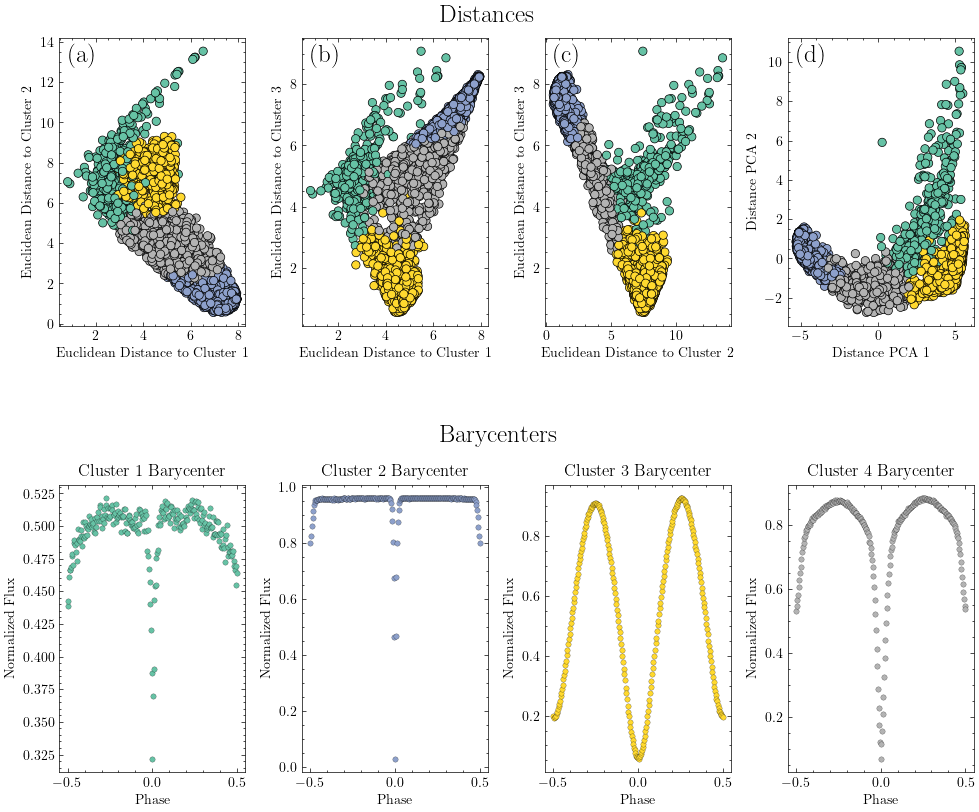

In [15]:
km = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=5,
                      random_state=1337).fit(scaled_ts)
cluster_labels = km.predict(scaled_ts)
distance_to_clusters = km.transform(scaled_ts)
distance_pca = PCA(n_components=2).fit_transform(distance_to_clusters)

fig = plt.figure(figsize=(10, 8)); gs = fig.add_gridspec(2, 4)

ax1a, ax2a, ax3a, ax4a = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3])
ax2, ax3, ax4, ax5 =  fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3])

axlista = [ax1a, ax2a, ax3a]; permut = [(0,1), (0,2), (1,2)]
[ax.scatter(distance_to_clusters[:, p[0]],  distance_to_clusters[:, p[1]], c=cluster_labels,
            cmap='Set2', edgecolor='k', lw=0.5) for (ax, p) in zip(axlista, permut)]
[ax.set_xlabel(f'Euclidean Distance to Cluster {p[0]+1}') for (ax, p) in zip(axlista, permut)]
[ax.set_ylabel(f'Euclidean Distance to Cluster {p[1]+1}') for (ax, p) in zip(axlista, permut)]
[ax.text(s=lbl, transform=ax.transAxes, x=0.05, y=0.92, fontsize=fs) for ax, lbl in zip(axlista+[ax4a], ['(a)', '(b)', '(c)', '(d)'])]
ax4a.scatter(distance_pca[:,0], distance_pca[:,1], c=cluster_labels, cmap='Set2', edgecolor='k', lw=0.5)
ax4a.set_xlabel('Distance PCA 1'); ax4a.set_ylabel('Distance PCA 2')

axlist = [ax2, ax3, ax4, ax5]
[ax.scatter(np.linspace(-.5, .5, 251), km.cluster_centers_[i], s=15, edgecolor='k', lw=0.15,
            color= cm.get_cmap('Set2', len(np.unique(cluster_labels)) )(i)) for i, ax in enumerate(axlist)]
[ax.set_xlabel('Phase') for ax in axlist]; [ax.set_ylabel('Normalized Flux') for ax in axlist]; [ax.set_title(f'Cluster {i+1} Barycenter') for i, ax in enumerate(axlist)]


fig.text(x=0.45, y=1, s='Distances', fontsize=fs)
fig.text(x=0.45, y=0.475, s='Barycenters', fontsize=fs)

plt.tight_layout(h_pad=7.5)
plt.show()

Notice that the barycenters are now exemplars that are of "intermediate" shape between the detached and the ellipsoidal scenarios. In panels (a-c), the 2D slices of the 4D projection shows not only similarities (affinities) across the dataset to a particular barycenter/template, but it shows how these affinities relate to one another. In panel (d), a 2D PCA mapping is performed to summarize information across the 4D Euclidean distance projection.

In [16]:
bokeh_projection_clust(distance_pca, cluster_labels, xlabel='Distance PCA 1',
                      ylabel='Distance PCA 2', title='4D Euclidean Clustering, Projected into 2D')

```{note}
Compare the representation power of this particular projection with all the other ones previously presented on this page? Does the similarity between eclipse shapes agree with their relative distances in this projection? Are the outliers and distance points sensible?
```
(content:similarity_distances)=
### Beyond Euclidean distances

The metric defined thus far simply computes the Euclidean distance $d$ between two time series $X=[x_1, x_2, \cdots, x_n]$ and $Y=[y_1, y_2,\cdots,y_n]$ as:
```{math}
:label: ts_euclidean
\begin{aligned}
\\ d(X,Y) = \left( \sum_{i=1}^n (x_i - y_i)^2 \right)^{1/2}.
\end{aligned}
```
A distinct limitation of this particular distance metric (noticeable in the interactive plots shown as well), is that it isn't particularly robust towards outliers. Additionally, optimizing for similarity across all $i$ timestamps simultaneously may not be the best way of identifying "conceptually" or "globally" similar shapes. Other distance metrics that can improve upon this are:

<b> 1. Cosine Distance </b>

This metric determines the dissimilarity of two vectors to one another, quantified as the angle between $X$ and $Y$:
```{math}
:label: ts_cosine
\begin{aligned}
\\ d(X,Y) = 1 - \frac{X\cdot Y}{\|X\|\|Y\|}.
\end{aligned}
```

<b> 2. Dynamic Time Warping (DTW) </b>

DTW determines the optimal alignment between two time series by accounting for shifts and distortions. Calculating this distance metric is often quite computationally expensive. It is defined as the following:
```{math}
:label: ts_cosine
\begin{aligned}
\\ d(X,Y) = \left( \min_w  \sum_{i,j}^n (x_i - y_j)^2 \right)^{1/2},
\end{aligned}
```
where $w$ is the warping path that minimizes the cumulative distance over all possible alignments. DTW typically assumes that the time series being compared have regular (or similar) time sampling, and will "warp" one series to align with the other by stretching or compressing parts of the series to minimize the distance between them.

<b> 3. Time Warp Edit Distance (TWED) </b>

Conceptually, TWED measures the "cost" of transforming one time series into another by considering, incurred when aligning both timestamps **and** flux values of the time series. This implies that it is able to align time series with different timestamps from one another. It presents the following form:
```{math}
:label: ts_twed
\begin{aligned}
\\ d(X,Y) =  \min_T ( \text{Cost(T)} + \text{Distance(X,Y)}), 
\end{aligned}
```
where $T$ represents the transformation path, while $\text{Cost(T)}$ indicates the penalty for alignment.

<b> 4. KShape </b>

Specifically designed for time series and sequence data, KShape uses a shape-based measure in the form of a correlation distance as a metric to capture the similarity across time series:
```{math}
:label: ts_kshape
\begin{aligned}
\\ d(X,Y) =  \frac{1 - C(X,Y)}{2}, 
\end{aligned}
```
where $C$ calculates the correlation coefficient between normalized time series $X$ and $Y$.


## Further Reading


[[1]](https://sigmodrecord.org/publications/sigmodRecord/1603/pdfs/18_kShape_RH_Paparrizos.pdf) J. Paparrizos and L. Gravano. k-Shape: Efficient and accurate clustering of time series. In SIGMOD, pages 1855–1870, 2015. doi:10.1145/2949741.2949758.

[[2]](https://csdl.ics.hawaii.edu/techreports/2008/08-04/08-04.pdf) Dynamic Time Warping Algorithm Review, Pavel Senin, December 2008.

[[3]](https://hal.science/hal-00135473v2/file/TWED_HAL_v1.pdf) Pierre-François Marteau. Time Warp Edit Distance with Stiffness Adjustment for Time Series Matching. 2006. `hal-00135473v2`

[[4]](https://tslearn.readthedocs.io/en/latest/index.html) Python Library `tslearn`